In [4]:
import zipfile
import sys
import os
import shutil
import random

# Data prep

### Extract & download Data

In [17]:
train_dir = zipfile.ZipFile('data/train.zip', 'r')
test_dir = zipfile.ZipFile('data/test.zip', 'r')

zipf = zipfile.ZipFile('data/train.zip')
zipf.extractall('./data')

In [18]:
zipf = zipfile.ZipFile('./data/test.zip')
zipf.extractall('./data')

### Copy/split Data

In [19]:
def get_file_list(input_dir):
    return [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]

def get_random_files(file_list, N):
    return random.sample(file_list, N)

def copy_files(random_files, input_dir, output_dir):
    for file in random_files:
        shutil.copy(os.path.join(input_dir, file), output_dir)

def main(input_dir, output_dir, N):
    file_list = get_file_list(input_dir)
    random_files = get_random_files(file_list, N)
    copy_files(random_files, input_dir, output_dir)

In [20]:
archive = zipfile.ZipFile('data/train.zip')

filelist = [archive.filelist[i].filename for i in range(len(archive.filelist)) if archive.filelist[i].filename.endswith('.png') ] 

random_files = get_random_files(filelist, int(len(filelist)*.2))
random_files[10]

'train/Sugar beet/7b4682569.png'

In [21]:
from shutil import copyfile

def copy_files_to_subdir(random_files):
  if not os.path.isdir('data/validation'):
    os.mkdir('data/validation')
  for file in random_files:
    classes = file.split('/')[1]
    filename = file.split('/')[-1]
    if os.path.isdir('data/validation/'+classes):
      copyfile('data/'+ file, 'data/validation/'+classes+'/'+filename)
    else:
      os.mkdir('data/validation/'+classes)
      copyfile('data/' + file, 'data/validation/'+classes+'/'+filename)

In [22]:
copy_files_to_subdir(random_files)

# ----- START FROM HERE -------

# Red CNN

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    directory=r"data/train",
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=32
)

Found 4750 images belonging to 12 classes.


In [3]:
valid_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40,
        horizontal_flip=True)

valid_generator = valid_datagen.flow_from_directory(
    directory=r"data/validation/",
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=32
)

Found 1329 images belonging to 12 classes.


In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D
from keras import backend as K
from keras.optimizers import RMSprop

In [5]:
bs = 32
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(128, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
#compile model using accuracy to measure model performance
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         401536    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [8]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=40,
        validation_data=valid_generator,
        validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
200/200 [==============================] - 92s 461ms/step - loss: 2.2203 - acc: 0.2857 - val_loss: 1.5714 - val_acc: 0.4221
Epoch 2/40
200/200 [==============================] - 77s 385ms/step - loss: 1.3755 - acc: 0.5052 - val_loss: 1.1248 - val_acc: 0.6164
Epoch 3/40
200/200 [==============================] - 84s 418ms/step - loss: 1.1116 - acc: 0.6149 - val_loss: 0.9471 - val_acc: 0.6618
Epoch 4/40
200/200 [==============================] - 88s 438ms/step - loss: 0.9653 - acc: 0.6532 - val_loss: 0.9167 - val_acc: 0.6713
Epoch 5/40
200/200 [==============================] - 93s 463ms/step - loss: 0.8916 - acc: 0.6826 - val_loss: 0.8270 - val_acc: 0.7117
Epoch 6/40
200/200 [==============================] - 85s 423ms/step - loss: 0.7765 - acc: 0.7341 - val_loss: 0.6941 - val_acc: 0.7541
Epoch 7/40
200/200 [==============================] - 84s 420ms/step - loss: 0.7049 - acc: 0.7524 - val_loss: 0.7516 - val_acc: 0.7199
Epoch 8

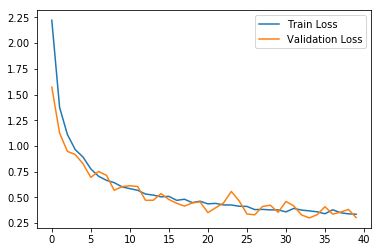

In [9]:
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [10]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    directory=r"data/test",
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=32
)

Found 794 images belonging to 1 classes.


In [11]:
import numpy as np
import pandas as pd

In [12]:
model.metrics_names
model.evaluate_generator(generator=valid_generator, steps=1)

[0.1638643890619278, 0.90625]

In [13]:
pred=model.predict_generator(test_generator,steps=794,verbose=1)

794/794 [==============================] - 5s 6ms/step


In [14]:
predicted_class_indices=np.argmax(pred,axis=1)

In [15]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [16]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [17]:
results

,Filename,Predictions
0,test\0021e90e4.png,Small-flowered Cranesbill
1,test\003d61042.png,Fat Hen
2,test\007b3da8b.png,Sugar beet
3,test\0086a6340.png,Common Chickweed
4,test\00c47e980.png,Sugar beet
5,test\00d090cde.png,Scentless Mayweed
6,test\00ef713a8.png,Common Chickweed
7,test\01291174f.png,Fat Hen
8,test\026716f9b.png,Loose Silky-bent
9,test\02cfeb38d.png,Loose Silky-bent
